In [1]:
import pandas as pd
import numpy as np
import random
import datetime
import matplotlib.pyplot as plt
import xgboost as xgb
import sklearn.metrics
from sklearn import model_selection
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, auc
from xgboost import XGBClassifier
from xgboost import plot_tree
import matplotlib.pyplot as plt
from scipy import interp
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import learning_curve,GridSearchCV
import shap
from shap import TreeExplainer
import matplotlib.pylab as pl

data = pd.read_csv("data.csv")
data.shape

(101766, 50)

In [2]:
#Remove "[", ")", ">", and "<"
data['age']=data['age'].str.replace('[','')
data['age']=data['age'].str.replace(')','')
data['weight']=data['weight'].str.replace('[','')
data['weight']=data['weight'].str.replace(')','')
data['max_glu_serum']=data['max_glu_serum'].str.replace('>','greater_than_')
data['A1Cresult']=data['A1Cresult'].str.replace('>','greater_than_')
data['readmitted']=data['readmitted'].str.replace('>','greater_than_')
data['readmitted']=data['readmitted'].str.replace('<','smaller_than_')


# Missing Values
Want to drop medical_specialty,weight ,payer_code for sure

In [3]:
#Checking for missing values in dataset
#In the dataset missing values are represented as '?' sign
for col in data.columns:
    if data[col].dtype == object:
         print(col,data[col][data[col] == '?'].count())

race 2273
gender 0
age 0
weight 98569
payer_code 40256
medical_specialty 49949
diag_1 21
diag_2 358
diag_3 1423
max_glu_serum 0
A1Cresult 0
metformin 0
repaglinide 0
nateglinide 0
chlorpropamide 0
glimepiride 0
acetohexamide 0
glipizide 0
glyburide 0
tolbutamide 0
pioglitazone 0
rosiglitazone 0
acarbose 0
miglitol 0
troglitazone 0
tolazamide 0
examide 0
citoglipton 0
insulin 0
glyburide-metformin 0
glipizide-metformin 0
glimepiride-pioglitazone 0
metformin-rosiglitazone 0
metformin-pioglitazone 0
change 0
diabetesMed 0
readmitted 0


In [4]:
data['readmitted_urgent'] = (data['readmitted'] == 'smaller_than_30').astype(int)

In [5]:
#Create new variable 'readmitted_yes' for binary classification
data['readmitted_yes']= (data['readmitted'] == 'greater_than_30').astype(int) +  (data['readmitted'] == 'smaller_than_30').astype(int) 

In [6]:
data.groupby(["readmitted_yes"])['readmitted_yes'].count()

readmitted_yes
0    54864
1    46902
Name: readmitted_yes, dtype: int64

In [7]:
data.groupby(["readmitted_urgent"])['readmitted_urgent'].count()

readmitted_urgent
0    90409
1    11357
Name: readmitted_urgent, dtype: int64

In [8]:
# Encode change column, diabetesMed column
# ch to Yes to 1, No to 1 
# gender: Male to 1, Female to 0
# DiabetesMed: Yed to 1, No to 0

In [9]:
data['change'] = data['change'].replace('Ch', 1)
data['change'] = data['change'].replace('No', 0)
data['diabetesMed'] = data['diabetesMed'].replace('Yes', 1)
data['diabetesMed'] = data['diabetesMed'].replace('No', 0)


In [10]:
# there are 24 features of medicine,which indicates whether the drug 
# was prescribed or there was a change in the dosage
# Possible values: “up” if the dosage was increased during the encounter, 
# “down” if the dosage was decreased, “steady” if the dosage did not change,
# and “no” if the drug was not prescribed

meds = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
        'glimepiride', 'glipizide', 'glyburide', 'pioglitazone',
        'rosiglitazone', 'acarbose', 'miglitol', 'insulin', 'glyburide-metformin',
        'tolazamide', 'metformin-pioglitazone','metformin-rosiglitazone', 'glimepiride-pioglitazone',
        'glipizide-metformin', 'troglitazone', 'tolbutamide', 'acetohexamide']

In [11]:
# Encode Up to 3, steady to 2, down to 1, no to 0
for col in meds:
    data[col] = data[col].replace('No', 0)
    data[col] = data[col].replace('Steady', 2)
    data[col] = data[col].replace('Up', 3)
    data[col] = data[col].replace('Down', 1)

In [12]:
data.groupby(['age'])['age'].count()

age
0-10        161
10-20       691
20-30      1657
30-40      3775
40-50      9685
50-60     17256
60-70     22483
70-80     26068
80-90     17197
90-100     2793
Name: age, dtype: int64

In [13]:

# Convert age to numerical, take the mid point of each interval, 5,15,25, etc

data['age'] = data['age'].replace('0-10', 5)
data['age'] = data['age'].replace('10-20', 15)
data['age'] = data['age'].replace('20-30', 25)
data['age'] = data['age'].replace('30-40', 35)
data['age'] = data['age'].replace('40-50', 45)
data['age'] = data['age'].replace('50-60', 55)
data['age'] = data['age'].replace('60-70', 65)
data['age'] = data['age'].replace('70-80', 75)
data['age'] = data['age'].replace('80-90', 85)
data['age'] = data['age'].replace('90-100', 95)

In [14]:
# convert examide and citoglipton to binary
data.groupby(['examide'])['examide'].count()
data.groupby(['citoglipton'])['citoglipton'].count()
# No need, all values are NO, just drop them

citoglipton
No    101766
Name: citoglipton, dtype: int64

In [15]:
# Drop payer_code, weight, medical_specialty, readmitted, examide, citoglipton
del_columns = ['weight', 'payer_code', 'medical_specialty','examide','citoglipton','readmitted']
data.drop(del_columns, inplace=True, axis=1)

In [16]:
id_list = []
encounter_list = []
for index, row in data.iterrows():
    if row['patient_nbr'] not in id_list:
        id_list.append(row['patient_nbr'])
        encounter_list.append(index)


In [17]:
df = data.iloc[list(encounter_list),:]

In [18]:
del_col = ["encounter_id","patient_nbr"]
df.drop(del_col, inplace=True, axis=1)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [19]:
df.drop(df[df.discharge_disposition_id == 11].index, inplace=True)
df.drop(df[df.discharge_disposition_id == 13].index, inplace=True)
df.drop(df[df.discharge_disposition_id == 14].index, inplace=True)
df.drop(df[df.discharge_disposition_id == 19].index, inplace=True)
df.drop(df[df.discharge_disposition_id == 20].index, inplace=True)
df.drop(df[df.discharge_disposition_id == 21].index, inplace=True)

In [20]:
df.drop(df[df.gender == "Unknown/Invalid"].index, inplace=True)

In [21]:
df.shape

(69970, 44)

In [22]:
# Recode diag1, diag2, diag3

df.loc[df['diag_1'].str.contains('V'), ['diag_1']] = "SUPPLEMENTARY"
df.loc[df['diag_2'].str.contains('V'), ['diag_2']] = "SUPPLEMENTARY"
df.loc[df['diag_3'].str.contains('V'), ['diag_3']] = "SUPPLEMENTARY"

df.loc[df['diag_1'].str.contains('E'), ['diag_1']] = "SUPPLEMENTARY_EXTERNAL"
df.loc[df['diag_2'].str.contains('E'), ['diag_2']] = "SUPPLEMENTARY_EXTERNAL"
df.loc[df['diag_3'].str.contains('E'), ['diag_3']] = "SUPPLEMENTARY_EXTERNAL"

df['diag_1'] = df['diag_1'].replace('?', "NONE")
df['diag_2'] = df['diag_2'].replace('?', "NONE")
df['diag_3'] = df['diag_3'].replace('?', "NONE")


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [23]:
#df['diag_1'] = pd.to_numeric(df['diag_1'], errors='ignore')
#df['diag_2']= pd.to_numeric(df['diag_2'], errors='ignore')
#df['diag_3']= pd.to_numeric(df['diag_3'], errors='ignore')

In [24]:
# Helper function to convert str to float
def change_to_num(col):
    res = []
    for i in col:
        if i not in {"NONE","SUPPLEMENTARY_EXTERNAL","SUPPLEMENTARY"}:
            res.append(float(i))
        else:
            res.append(i)
    return res
        

In [25]:
df['diag_1'] = change_to_num(df['diag_1'])
df['diag_2'] = change_to_num(df['diag_2'])
df['diag_3'] = change_to_num(df['diag_3'])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [26]:
df['diag_1']

0                         250.83
1                            276
2                            648
3                              8
4                            197
5                            414
6                            414
7                            428
8                            398
9                            434
10                         250.7
11                           157
12                           428
13                           428
14                           518
15                           999
16                           410
17                           682
18                           402
19                           737
20                           410
21                           572
22                           410
23        SUPPLEMENTARY_EXTERNAL
24                           189
25                           786
26                           427
27                           996
28                           277
29                           428
          

In [27]:
new_diag_1 = []
for index, row in df.iterrows():
    if row['diag_1'] not in {"NONE","SUPPLEMENTARY_EXTERNAL","SUPPLEMENTARY"}:
        if (row['diag_1'] >= 1 and row['diag_1'] <= 139):
            new_diag_1.append("INFECTIOUS_PARASTIC_DISEASE")
        elif (row['diag_1'] >= 140 and row['diag_1'] <= 239):
            new_diag_1.append("NEOPLASMS")
        elif (row['diag_1'] >= 240 and row['diag_1'] <= 279):
            new_diag_1.append("ENDO_NUTRI_METABOLIC")
        elif (row['diag_1'] >= 280 and row['diag_1'] <= 289):
            new_diag_1.append("BLOOD_ORGANS_DISEASE")
        elif (row['diag_1'] >= 290 and row['diag_1'] <= 319):
            new_diag_1.append("MENTAL_DISORDER")
        elif (row['diag_1'] >= 320 and row['diag_1'] <= 389):
            new_diag_1.append("NERVOUS_SENSE_DISEASE")
        elif (row['diag_1'] >= 390 and row['diag_1'] <= 459):
            new_diag_1.append("CIRCULATORY_SYSTEM_DISEASE")
        elif (row['diag_1'] >= 460 and row['diag_1'] <= 519):
            new_diag_1.append("RESPIRATORY_SYSTEM_DISEASE")
        elif (row['diag_1'] >= 520 and row['diag_1'] <= 579):
            new_diag_1.append("DIGESTIVE_SYSTEM_DISEASE")
        elif (row['diag_1'] >= 580 and row['diag_1'] <= 629):
            new_diag_1.append("GENETOURINARY_SYSTEM_DISEASE")
        elif (row['diag_1'] >= 630 and row['diag_1'] <= 679):
            new_diag_1.append("PREGNANCY")
        elif (row['diag_1'] >= 680 and row['diag_1'] <= 709):
            new_diag_1.append("SKIN_DISEASE")
        elif (row['diag_1'] >= 710 and row['diag_1'] <= 739):
            new_diag_1.append("MUSCULOSKELETAL_SYSTEM_DISEASE")
        elif (row['diag_1'] >= 740 and row['diag_1'] <= 759):
            new_diag_1.append("CONGENITAL_ANOMALIES")
        elif (row['diag_1'] >= 760 and row['diag_1'] <= 779):
            new_diag_1.append("PERINATAL_PERIOD")
        elif (row['diag_1'] >= 780 and row['diag_1'] <= 799):
            new_diag_1.append("ILL_DEFINED_COND")
        elif (row['diag_1'] >= 800 and row['diag_1'] <= 999):
            new_diag_1.append("INJURY_POISONING")
    else:
        new_diag_1.append(row['diag_1'])


In [28]:
df['diag_1'] = pd.Series(new_diag_1)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [29]:
new_diag_2 = []
for index, row in df.iterrows():
    if row['diag_2'] not in {"NONE","SUPPLEMENTARY_EXTERNAL","SUPPLEMENTARY"}:
        if (row['diag_2'] >= 1 and row['diag_2'] <= 139):
            new_diag_2.append("INFECTIOUS_PARASTIC_DISEASE")
        elif (row['diag_2'] >= 140 and row['diag_2'] <= 239):
            new_diag_2.append("NEOPLASMS")
        elif (row['diag_2'] >= 240 and row['diag_2'] <= 279):
            new_diag_2.append("ENDO_NUTRI_METABOLIC")
        elif (row['diag_2'] >= 280 and row['diag_2'] <= 289):
            new_diag_2.append("BLOOD_ORGANS_DISEASE")
        elif (row['diag_2'] >= 290 and row['diag_2'] <= 319):
            new_diag_2.append("MENTAL_DISORDER")
        elif (row['diag_2'] >= 320 and row['diag_2'] <= 389):
            new_diag_2.append("NERVOUS_SENSE_DISEASE")
        elif (row['diag_2'] >= 390 and row['diag_2'] <= 459):
            new_diag_2.append("CIRCULATORY_SYSTEM_DISEASE")
        elif (row['diag_2'] >= 460 and row['diag_2'] <= 519):
            new_diag_2.append("RESPIRATORY_SYSTEM_DISEASE")
        elif (row['diag_2'] >= 520 and row['diag_2'] <= 579):
            new_diag_2.append("DIGESTIVE_SYSTEM_DISEASE")
        elif (row['diag_2'] >= 580 and row['diag_2'] <= 629):
            new_diag_2.append("GENETOURINARY_SYSTEM_DISEASE")
        elif (row['diag_2'] >= 630 and row['diag_2'] <= 679):
            new_diag_2.append("PREGNANCY")
        elif (row['diag_2'] >= 680 and row['diag_2'] <= 709):
            new_diag_2.append("SKIN_DISEASE")
        elif (row['diag_2'] >= 710 and row['diag_2'] <= 739):
            new_diag_2.append("MUSCULOSKELETAL_SYSTEM_DISEASE")
        elif (row['diag_2'] >= 740 and row['diag_2'] <= 759):
            new_diag_2.append("CONGENITAL_ANOMALIES")
        elif (row['diag_2'] >= 760 and row['diag_2'] <= 779):
            new_diag_2.append("PERINATAL_PERIOD")
        elif (row['diag_2'] >= 780 and row['diag_2'] <= 799):
            new_diag_2.append("ILL_DEFINED_COND")
        elif (row['diag_2'] >= 800 and row['diag_2'] <= 999):
            new_diag_2.append("INJURY_POISONING")
    else:
        new_diag_2.append(row['diag_2'])

df['diag_2'] = pd.Series(new_diag_2)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [30]:
new_diag_3 = []
for index, row in df.iterrows():
    if row['diag_3'] not in {"NONE","SUPPLEMENTARY_EXTERNAL","SUPPLEMENTARY"}:
        if (row['diag_3'] >= 1 and row['diag_3'] <= 139):
            new_diag_3.append("INFECTIOUS_PARASTIC_DISEASE")
        elif (row['diag_3'] >= 140 and row['diag_3'] <= 239):
            new_diag_3.append("NEOPLASMS")
        elif (row['diag_3'] >= 240 and row['diag_3'] <= 279):
            new_diag_3.append("ENDO_NUTRI_METABOLIC")
        elif (row['diag_3'] >= 280 and row['diag_3'] <= 289):
            new_diag_3.append("BLOOD_ORGANS_DISEASE")
        elif (row['diag_3'] >= 290 and row['diag_3'] <= 319):
            new_diag_3.append("MENTAL_DISORDER")
        elif (row['diag_3'] >= 320 and row['diag_3'] <= 389):
            new_diag_3.append("NERVOUS_SENSE_DISEASE")
        elif (row['diag_3'] >= 390 and row['diag_3'] <= 459):
            new_diag_3.append("CIRCULATORY_SYSTEM_DISEASE")
        elif (row['diag_3'] >= 460 and row['diag_3'] <= 519):
            new_diag_3.append("RESPIRATORY_SYSTEM_DISEASE")
        elif (row['diag_3'] >= 520 and row['diag_3'] <= 579):
            new_diag_3.append("DIGESTIVE_SYSTEM_DISEASE")
        elif (row['diag_3'] >= 580 and row['diag_3'] <= 629):
            new_diag_3.append("GENETOURINARY_SYSTEM_DISEASE")
        elif (row['diag_3'] >= 630 and row['diag_3'] <= 679):
            new_diag_3.append("PREGNANCY")
        elif (row['diag_3'] >= 680 and row['diag_3'] <= 709):
            new_diag_3.append("SKIN_DISEASE")
        elif (row['diag_3'] >= 710 and row['diag_3'] <= 739):
            new_diag_3.append("MUSCULOSKELETAL_SYSTEM_DISEASE")
        elif (row['diag_3'] >= 740 and row['diag_3'] <= 759):
            new_diag_3.append("CONGENITAL_ANOMALIES")
        elif (row['diag_3'] >= 760 and row['diag_3'] <= 779):
            new_diag_3.append("PERINATAL_PERIOD")
        elif (row['diag_3'] >= 780 and row['diag_3'] <= 799):
            new_diag_3.append("ILL_DEFINED_COND")
        elif (row['diag_3'] >= 800 and row['diag_3'] <= 999):
            new_diag_3.append("INJURY_POISONING")
    else:
        new_diag_3.append(row['diag_3'])

df['diag_3'] = pd.Series(new_diag_3)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [31]:
df.to_csv("~/Desktop/recode_data.csv",index=False)

In [32]:
df.groupby(['gender'])['gender'].count()

gender
Female    37229
Male      32741
Name: gender, dtype: int64

In [33]:
df.drop(df[df.gender == "Unknown/Invalid"].index, inplace=True)

In [34]:
df.groupby(['gender'])['gender'].count()

gender
Female    37229
Male      32741
Name: gender, dtype: int64

In [35]:
df_2 = pd.get_dummies(df, columns=['diag_1','diag_2','diag_3','max_glu_serum',
                                   'A1Cresult','race','gender',
                                   'admission_type_id',
                                   'discharge_disposition_id','admission_source_id'], drop_first=True)

In [36]:
df_2.columns

Index(['age', 'time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'metformin',
       ...
       'admission_source_id_8', 'admission_source_id_9',
       'admission_source_id_10', 'admission_source_id_11',
       'admission_source_id_13', 'admission_source_id_14',
       'admission_source_id_17', 'admission_source_id_20',
       'admission_source_id_22', 'admission_source_id_25'],
      dtype='object', length=140)

In [38]:
#Construct predicted variable 'readmitted_yes' and predictors
Y=df_2['readmitted_yes']
X=df_2.drop('readmitted_urgent',axis=1)
X=X.drop('readmitted_yes',axis=1)
seed = 7
test_size = 0.33
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=test_size, random_state=seed)

XGBoost - Model Construction

Since logistic regression cannot generate a satisfying result with a high true positive rate and area under the curve, we decided to use an XGBoost model to obtain a better performance. The first reason we decided to use the XGBoost model is that it can reduce bias by adding new trees in the model. The model also contains a built-in cross-validation method to tune various hyperparameters. Last but not least, the model contains a regularization parameter that can reduce overfitting. Due to the reasons above, we decided to construct an XGBoost model with optimal hyperparameters obtained by cross-validation.

In [39]:
dtrain = xgb.DMatrix(X_train, label=Y_train)
dtest = xgb.DMatrix(X_test, label=Y_test)

Series.base is deprecated and will be removed in a future version


Parameter Tuning

In [40]:
#Define function for tuning the number of estimators
def modelfit(alg, X_train, y_train, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        dtrain = xgb.DMatrix(X_train, label=y_train)
        xgb_param = alg.get_xgb_params()
        xgtrain = dtrain
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X_train, y_train,eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(X_train)
    dtrain_predprob = alg.predict_proba(X_train)[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("The optimal number of trees is ", cvresult.shape[0])
    print ("Accuracy : %.4g" % sklearn.metrics.accuracy_score(y_train, dtrain_predictions))
    print ("AUC Score (Train): %f" % sklearn.metrics.roc_auc_score(y_train, dtrain_predprob))

To Tune the parameters of the XGBoost Model, we decided to use the 5-fold cross-validation on the training data. We first tune the number of estimators included in the model with a learning rate of 0.1. The optimum number of estimators is shown below:

In [41]:
#Tune the number of estimators
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=500,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, X_train, Y_train)


Model Report
The optimal number of trees is  225
Accuracy : 0.6905
AUC Score (Train): 0.744665


Next, we decided to train the maximum depth and minimum child weight of each tress. The outcome is shown below:

In [42]:
#Tune max_depth and min_child_weight
param_test1 = {
 'max_depth':range(2,8,2),
 'min_child_weight':range(0,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=225, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train,Y_train)
gsearch1.best_params_

{'max_depth': 4, 'min_child_weight': 4}

Since the increment for the maximum depth and minimum child weight for each tree is 2, we decided to tune these two parameters with a finer increment. The result is shown below:

In [43]:
param_test2 = {
 'max_depth':[3,4,5],
 'min_child_weight':[3,4,5]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=225, max_depth=4,
 min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(X_train,Y_train)
gsearch2.best_params_

{'max_depth': 4, 'min_child_weight': 3}

After tuning the maximum depth and minimum child weight, we wanted to tune the minimum loss reduction requirement gamma for tree partitioning. The result is shown below:

In [44]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=225, max_depth=4,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(X_train,Y_train)
gsearch3.best_params_

{'gamma': 0.0}

After tuning the model's maximum depth, minimum child weight, and gamma, we wanted to tune the optimum number of trees again. The result is shown below:

In [45]:
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=500,
 max_depth=4,
 min_child_weight=3,
 gamma=0.0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb2, X_train, Y_train)

Series.base is deprecated and will be removed in a future version



Model Report
The optimal number of trees is  344
Accuracy : 0.6788
AUC Score (Train): 0.727349


After tuning the optimal number of parameters again, we wanted to tune the subsample ratio of the training data and the total variables to prevent overfitting. The result is shown below:

In [46]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=344, max_depth=4,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(X_train,Y_train)
gsearch4.best_params_

{'colsample_bytree': 0.6, 'subsample': 0.6}

After tuning the subsample ratios for training data and variables, we wanted to tune the L1 regularization parameter alpha. The result is shown below:

In [47]:
param_test5 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=344, max_depth=4,
 min_child_weight=3, gamma=0, subsample=0.6, colsample_bytree=0.6,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(X_train,Y_train)
gsearch5.best_params_

{'reg_alpha': 1}

Now we wanted to tune alpha with a finer increment. The optimal alpha is shown below:

In [48]:
param_test6 = {
 'reg_alpha':[1, 5, 10]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=344, max_depth=4,
 min_child_weight=3, gamma=0, subsample=0.6, colsample_bytree=0.6, reg_alpha=1,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(X_train,Y_train)
gsearch6.best_params_

{'reg_alpha': 5}

After tuning all parameters of the model, we reduced the learning rate from 0.1 to 0.01 and tried to find the optimal number of trees given the 0.01 learning rate. The outcome is shown below:

In [49]:
xgb3 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=5000,
 max_depth=4,
 min_child_weight=3,
 gamma=0,
 subsample=0.6,
 colsample_bytree=0.6,
 reg_alpha=5,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb3, X_train, Y_train)

Series.base is deprecated and will be removed in a future version



Model Report
The optimal number of trees is  2944
Accuracy : 0.665
AUC Score (Train): 0.707981


After tuning all the parameters, we trained the XGBoost Model with our training data. By fitting the model on the training data, we obtained a training accuracy and a true positive rate shown below:

In [50]:
model_param = {'max_depth': 4,'min_child_weight': 3, 'eta': 0.01, 'gamma': 0, 'subsample': 0.6,'colsample_bytree': 0.6,'reg_alpha': 5,'objective': 'binary:logistic','nthread': 4,'scale_pos_weight': 1,'seed': 27,'eval_metric': 'auc'}
num_round=2944
model = xgb.train(model_param, dtrain, num_round)

In [54]:
# evaluate training accuracy
y_train_pred = model.predict(dtrain)
predictions_train = []
for value in y_train_pred:
    if value <=0.4:
        predictions_train.append(0)
    else:
        predictions_train.append(1)
accuracy_train = sklearn.metrics.accuracy_score(Y_train, predictions_train)
print("Training Accuracy: %.2f%%" % (accuracy_train * 100.0))
tn, fp, fn, tp = confusion_matrix(Y_train, predictions_train).ravel()
print("Training True Positive Rate: %.2f%%" % (tp/(tp+fn) * 100.0))

Training Accuracy: 64.87%
Training True Positive Rate: 66.29%


The ROC curve is shown below, with an area under the curve as 0.71.

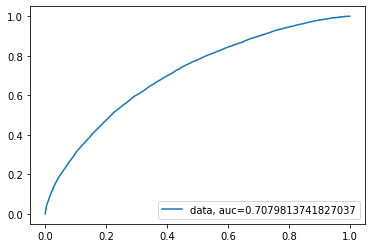

In [55]:
fpr, tpr, _ = sklearn.metrics.roc_curve(Y_train,  y_train_pred)
auc = sklearn.metrics.roc_auc_score(Y_train,  y_train_pred)
plt.plot(fpr,tpr,label="data, auc="+str(auc))
plt.legend(loc=4)
plt.show()

After evaluating the performance of the model on the training data, we need to evaluate the model's performance on the test data. The testing accuracy and true positive rate are shown below:

In [66]:
# evaluate predictions accuracy
ypred = model.predict(dtest)
predictions = []
for value in ypred:
    if value <=0.4:
        predictions.append(0)
    else:
        predictions.append(1)
accuracy = sklearn.metrics.accuracy_score(Y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
tn, fp, fn, tp = confusion_matrix(Y_test, predictions).ravel()
print("Test True Positive Rate: %.2f%%" % (tp/(tp+fn) * 100.0))

Accuracy: 62.45%
Test True Positive Rate: 64.63%


The ROC curve of the test data is shown below, with an area under the curve of 0.68.

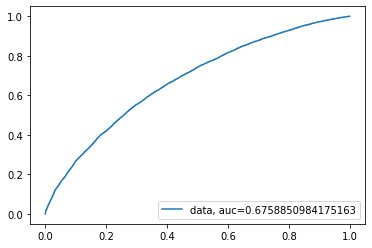

In [57]:
fpr, tpr, _ = sklearn.metrics.roc_curve(Y_test, ypred)
auc = sklearn.metrics.roc_auc_score(Y_test, ypred)
plt.plot(fpr,tpr,label="data, auc="+str(auc))
plt.legend(loc=4)
plt.show() 

To further analyze the XGBoost Model, we want to understand which features are more important in determining readmission. We first plotted the importance plots with weight, cover, and gain as the options below.

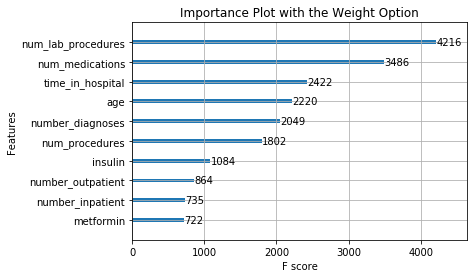

In [58]:
xgb.plot_importance(model, importance_type="weight",max_num_features=10)
pl.title("Importance Plot with the Weight Option")
pl.show()

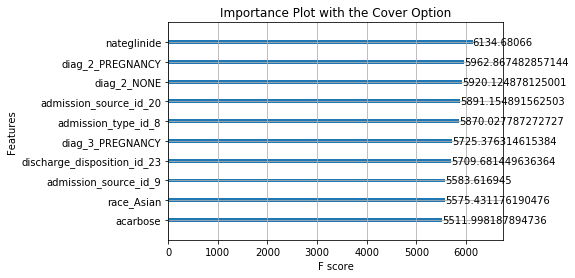

In [59]:
xgb.plot_importance(model, importance_type="cover",max_num_features=10)
pl.title("Importance Plot with the Cover Option")
pl.show()

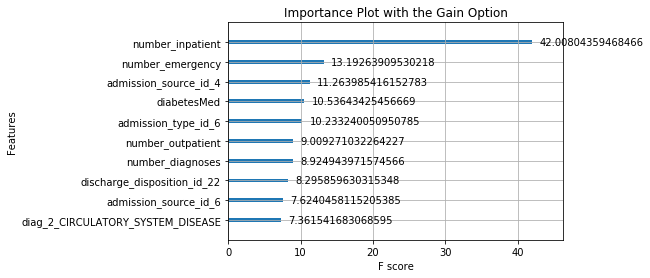

In [60]:
xgb.plot_importance(model, importance_type="gain",max_num_features=10)
pl.title("Importance Plot with the Gain Option")
pl.show()

From the three importance plots above, we can see that the most important features are different on each plot. It would be difficult to distinguish the impotance of different features truly. Therefore, we decided to use the Shapley Additive exPlanations (SHAP) values to interpret features. The twenty features with the highest SHAP is plotted below.

In [61]:
shap_values2=shap.TreeExplainer(model).shap_values(X_test)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


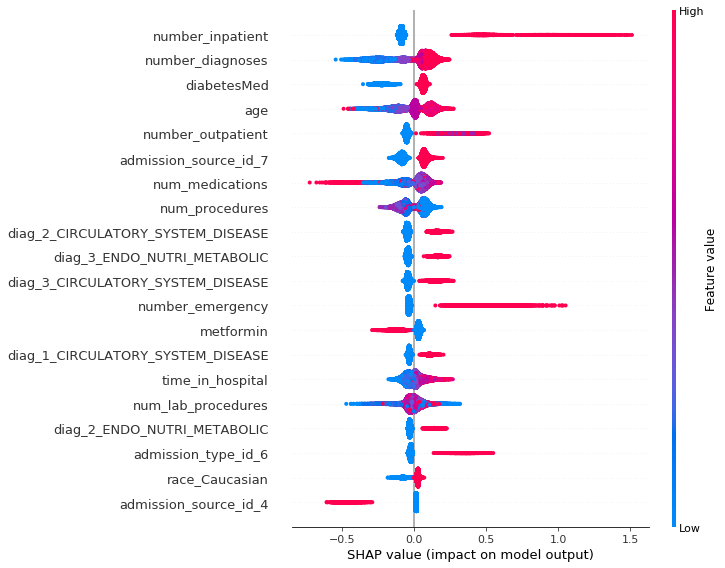

In [62]:
shap.summary_plot(shap_values2,X_test)

From the Shap plot above, we can see that the most important features in our model include number of inpatient visits of the patient in the year preceding the encounter, the number of diagnoses entered to the system, whether diabetes medication has been prescribed, patient's age, and the number of outpatient visits of the patient. We can see that readmission probability is positively correlated with the number of inpatient visits, the number of diagnoses entered, age, and the number of outpatient visits. Patient being prescribed with diabetes medication also has a higher probability of being readmitted. An important feature that should be analyzed further is metformin medication. The metformin medication is the first-line medication for the treatment of type 2 diabetes. To further analyze the relationship between the metformin medication and the readmission probability, we plotted the dependence plot below:

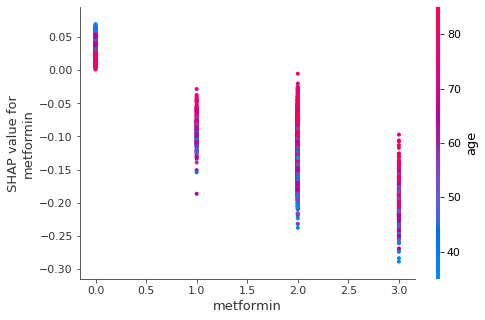

In [67]:
shap.dependence_plot("metformin", shap_values2, X_test)

From the dependence plot above, we can see that, for people with age less than 60, an increase in metformin medication can decrease readmission probability. However, for people age 60 or above, the relationship between metformin medication and readmission probability is less significant.

Conclusion

In this project, our objective is to predict the probability of readmission for diabetes patients. We have conducted data cleaning on the diabetes patients dataset from 130 US hospitals from 1999 to 2008 to remove variables with a high percentage of missing values and features with zero variability. Since each diagnosis has hundreds of ICD9 values, we decided to group these values into twenty disease categories to improve efficiency for model construction.

To conduct prediction on readmission probability, we have constructed a logistic regression model and an XGBoost model. To obtain the optimal performance on the XGBoost model, we used fivefold cross-validation to tune hyperparameters including maximum depth for each tree, minimum child weight, gamma which specifies the minimum loss reduction required for each split, the fraction of observations to be randomly sampled for each tree, the fraction of features to be randomly sampled for each tree, and the L1 regularization parameter alpha. By training the XGBoost model on the training set and fitting it on the test set, AUC of the training set and the test set are 0.71 and 0.68, respectively. The training and test recall are 66.29% and 64.63%, respectively. The result shows that the XGBoost model has a better performance than the logistic regression model. To discover important features of the XGBoost model and their relationship with readmission probability, we have constructed a Shap value plot and dependence plot. We discovered that the number of inpatient visits, number of diagnoses in the system, whether diabetes medication has been prescribed, patient's age, and the number of outpatient visits are the most important features in our model. Another important feature that is worth to be further analyzed is metformin medication. We have discovered that for patients with age less than 60, taking metformin may reduce the probability of readmission. This finding may encourage hospitals to analyze further the positive effect of metformin medication on diabetes patients.

There is one improvement that can be made to our model. Although we grouped various diagnoses into more general categories for model efficiency, we might have missed some important disease that can significantly affect readmission. By including these diseases in our model features, we might be able to improve our model performance.